# Aplicación del modelo K-MEANS

## Objetivo del Análisis
En este notebook, abordaremos la siguiente fase del proceso de segmentación: la aplicación definitiva del modelo K-Means sobre el conjunto de variables optimizado en el análisis anterior. Nuestro objetivo es identificar los grupos homogéneos de clientes de una manera más precisa y robusta, permitiendo un entendimiento profundo de los diferentes segmentos.

---

## Pasos a Realizar
1. **Entrenamiento del Modelo K-Means**  
   Aplicaremos el modelo sobre las variables seleccionadas y analizaremos la estructura de los clústeres generados.

2. **Evaluación del Modelo**  
   Se evaluará el desempeño del clustering utilizando métricas como:
   - *Inertia* (Suma de distancias al cuadrado dentro de los clústeres)
   - *Silhouette Score* (Medida de cohesión y separación entre grupos)

3. **Visualización de los Clústeres**  
   Se generarán representaciones gráficas para identificar patrones y diferencias entre los segmentos.

4. **Interpretación de Resultados**  
   Se interpretarán los insights obtenidos, destacando las características distintivas de cada grupo.

---

## Selección del Número Óptimo de Clústeres

Antes de aplicar el algoritmo K-Means para segmentar a los clientes activos, es fundamental determinar el número adecuado de clústeres (`k`). Elegir un valor apropiado permite generar grupos coherentes, estables y útiles para la toma de decisiones de marketing.

### Enfoque Utilizado

Se emplean dos métodos complementarios:

1. **Método del Codo**: Evalúa la inercia (suma de distancias al centroide) en función del número de clústeres. El "codo" de la curva indica un punto a partir del cual añadir más clústeres no mejora significativamente la agrupación.

2. **Silhouette Score**: Mide la calidad de la segmentación, es decir, cuán similares son los elementos dentro de un clúster en comparación con otros clústeres. Valores cercanos a 1 indican clústeres bien separados.

### Datos Utilizados

La evaluación se realiza sobre los clientes activos (`customer_segmentation_active`), utilizando las variables numéricas previamente escaladas mediante `StandardScaler`.

### Rango Evaluado

Se prueban valores de `k` entre 2 y 10, graficando los resultados de ambos métodos para facilitar la decisión.

Este análisis permite seleccionar un número de clústeres equilibrado, maximizando la calidad y estabilidad de la segmentación.


In [1]:
import pandas as pd
from sqlalchemy import create_engine,text
import os
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.stats import shapiro
from scipy.stats.mstats import winsorize
from scipy.stats import mstats
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import numpy as np
import geopandas as gpd
import contextily as cx

In [2]:
# Cargar variables de entorno
load_dotenv(override=True)

# Configuración de conexión
DB_HOST = os.getenv("DB_HOST")
DB_NAME = os.getenv("DB_NAME")
DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_PORT = os.getenv("DB_PORT")

# Crear el motor de conexión a PostgreSQL
engine = create_engine(f"postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}")


Calculando la inercia para el Método del Codo...
K=2 -> Inercia: 209490.1602835707 | Silhouette: 0.7054091642556436
K=3 -> Inercia: 181463.9882292122 | Silhouette: 0.3494219888943924
K=4 -> Inercia: 166745.37045397368 | Silhouette: 0.2486283352876603
K=5 -> Inercia: 154072.3163963165 | Silhouette: 0.16186598458240223
K=6 -> Inercia: 146334.560850294 | Silhouette: 0.14406773731124162
K=7 -> Inercia: 139253.82331608614 | Silhouette: 0.14751476761697632
K=8 -> Inercia: 147503.70004371207 | Silhouette: 0.24114298439963844
K=9 -> Inercia: 144938.03777449642 | Silhouette: 0.2325016935289366
K=10 -> Inercia: 130219.41999925784 | Silhouette: 0.13278588698303984


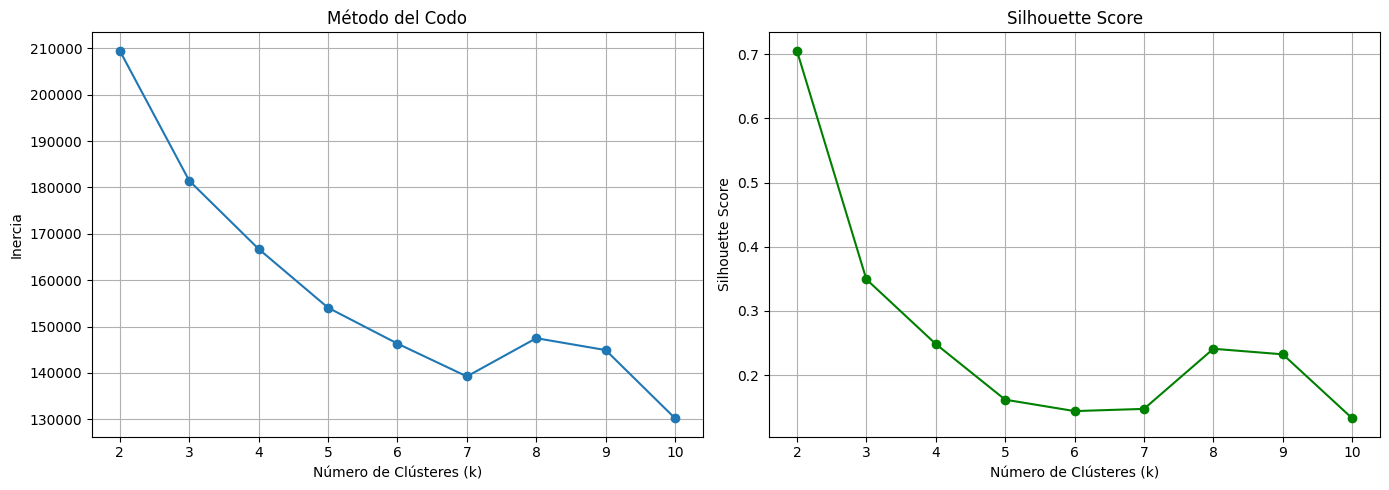

CPU times: total: 18min 24s
Wall time: 6min 26s


In [3]:
%%time
# ==============================
#    CARGA DE DATOS
# ==============================
query = """
SELECT 
    total_amount_sum_log,
    avg_order_value_log,
    average_time_transaction_winsorized,
    promo_usage_rate_log,
    avg_promo_discount_log,
    age_winsorized,
    recency_days_log,
    first_purchase_days,
    device_type_mode_encoded,
    traffic_source_mode_encoded,
    most_used_payment_credit_card,
    most_used_payment_gopay,
    most_used_payment_ovo,
    most_used_payment_debit_card,
    most_used_payment_linkaja,
    customer_gender_encoded,
    home_location_freq_encoded
FROM customer_segmentation_normalized
"""

# Leer los datos en un DataFrame
df = pd.read_sql_query(query, engine)

# ==============================
#    MÉTODO DEL CODO
# ==============================
print("\nCalculando la inercia para el Método del Codo...")
inertias = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(df, kmeans.labels_))
    print(f"K={k} -> Inercia: {kmeans.inertia_} | Silhouette: {silhouette_score(df, kmeans.labels_)}")

# ==============================
#    VISUALIZACIÓN DE RESULTADOS
# ==============================
plt.figure(figsize=(14, 5))

# Método del Codo
plt.subplot(1, 2, 1)
plt.plot(K_range, inertias, marker='o')
plt.title('Método del Codo')
plt.xlabel('Número de Clústeres (k)')
plt.ylabel('Inercia')
plt.grid(True)

# Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_scores, marker='o', color='green')
plt.title('Silhouette Score')
plt.xlabel('Número de Clústeres (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)

plt.tight_layout()
plt.show()


### Análisis para la Selección del Número Óptimo de Clústeres

Para determinar el número óptimo de clústeres en el proceso de segmentación de clientes, se han utilizado dos técnicas complementarias: el **Método del Codo** (basado en la inercia del modelo K-Means) y la métrica de **Silhouette Score**, que evalúa la cohesión interna y separación entre clústeres.

#### 1. Método del Codo (Inercia)
La inercia representa la suma de las distancias cuadradas entre cada punto y el centroide de su clúster. A medida que aumentamos el número de clústeres, la inercia disminuye, ya que los puntos están más cerca de sus centroides. Sin embargo, llega un punto donde el beneficio marginal de añadir un nuevo clúster empieza a decrecer significativamente. Este punto se conoce como el "codo".

- En el gráfico, se observa una disminución abrupta de la inercia entre **k = 2** y **k = 4**, lo cual indica una mejora significativa en la compactación de los clústeres.
- A partir de **k = 5**, la pendiente de la curva comienza a suavizarse, lo que sugiere que añadir más clústeres no aporta una mejora sustancial en términos de reducción de inercia.
- En **k = 8** se observa un pequeño aumento inesperado en la inercia, lo cual puede ser indicativo de una partición menos eficiente o de datos ruidosos en esa estructura.

#### 2. Silhouette Score
El Silhouette Score mide qué tan similar es un punto a su propio clúster en comparación con otros clústeres. Sus valores oscilan entre -1 y 1, donde valores cercanos a 1 indican una buena separación entre clústeres.

- El valor más alto se alcanza con **k = 2**, con un Silhouette Score de aproximadamente **0.705**, lo cual indica una excelente separación entre los dos grupos formados. Sin embargo, una segmentación en solo dos grupos puede ser demasiado simplista desde el punto de vista del marketing.
- A medida que se incrementa `k`, el Silhouette Score disminuye progresivamente, alcanzando valores más bajos en configuraciones con más clústeres.
- Curiosamente, en **k = 8** se observa un segundo pico del Silhouette Score, con un valor superior al de k = 5 a 7. Esto podría indicar que una estructura de ocho clústeres logra capturar subgrupos diferenciados dentro de los datos, aunque con menor cohesión que en k = 2.

#### Conclusión y Recomendación
A partir de los dos métodos, se proponen las siguientes opciones dependiendo del objetivo del análisis:

- Si se busca una **segmentación simple, interpretable y accionable**, **k = 4 o k = 5** es una elección adecuada. En estos valores se observa un equilibrio razonable entre la reducción de inercia y una separación aceptable entre los grupos.
  
- Si el objetivo es lograr una **segmentación más detallada y granular**, capaz de capturar patrones más específicos en el comportamiento de los clientes, puede considerarse **k = 8**. Aunque el Silhouette Score es más bajo que para k = 2, sigue siendo relativamente bueno en comparación con otros valores de `k`, y permite distinguir más perfiles dentro de la base de datos.

La elección definitiva de `k` también debe guiarse por el contexto de negocio, la viabilidad de activar cada segmento de forma diferenciada, y los insights obtenidos en el análisis posterior de los centroides y características de cada grupo.


In [8]:
%%time
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd

# Ajustar los modelos
kmeans_4 = KMeans(n_clusters=4, random_state=42).fit(df)
kmeans_5 = KMeans(n_clusters=5, random_state=42).fit(df)

# Obtener métricas
inertia_4 = kmeans_4.inertia_
inertia_5 = kmeans_5.inertia_
silhouette_4 = silhouette_score(df, kmeans_4.labels_)
silhouette_5 = silhouette_score(df, kmeans_5.labels_)

# Mostrar resultados
comparison_df = pd.DataFrame({
    "Métrica": ["Inercia", "Silhouette Score"],
    "k=4": [inertia_4, silhouette_4],
    "k=5": [inertia_5, silhouette_5]
})

comparison_df

,Métrica,k=4,k=5
0,Inercia,166744.803426,164544.007257
1,Silhouette Score,0.362090,0.337184


### Comparativa entre k = 4 y k = 5

Se ha realizado una comparativa entre los modelos K-Means con k = 4 y k = 5 clústeres, evaluando tanto métricas cuantitativas como cualitativas para determinar cuál ofrece una segmentación más adecuada.

#### 1. Métricas de rendimiento

| Métrica            | k = 4           | k = 5           |
|--------------------|------------------|------------------|
| Inercia            | 166,744.80        | 164,544.01        |
| Silhouette Score   | 0.3621            | 0.3372            |

- La inercia disminuye ligeramente al pasar de k = 4 a k = 5, lo cual es esperable al aumentar el número de clústeres, ya que cada grupo contiene puntos más cercanos a su centroide.
- No obstante, el **Silhouette Score es mayor con k = 4**, lo que indica que los clústeres tienen mayor cohesión interna y mejor separación respecto a los demás.

#### 2. Interpretabilidad y diferenciación

- Con **k = 4**, los clústeres obtenidos son más nítidos y diferenciables, lo que facilita su interpretación desde una perspectiva de marketing (por ejemplo: compradores intensivos, nuevos clientes, sensibles al precio, etc.).
- En cambio, **k = 5 introduce un nuevo grupo que no añade una segmentación sustancialmente diferente** y presenta una ligera pérdida en la calidad de separación, lo que puede generar confusión o redundancia en la aplicación de estrategias comerciales.

#### 3. Aplicabilidad práctica

- Trabajar con 4 segmentos es más manejable a nivel operativo y permite diseñar campañas o acciones específicas para cada grupo sin sobrecargar los recursos analíticos o de marketing.
- Aunque 5 clústeres ofrecen una segmentación más fina, el coste de esa complejidad no se justifica por una mejora significativa en las métricas ni en la claridad analítica.

#### Conclusión

La comparación muestra que, aunque ambos modelos son válidos, **k = 4 resulta una opción más robusta y eficaz**. Presenta un mejor equilibrio entre simplicidad, calidad de segmentación y utilidad práctica, facilitando una interpretación clara y una aplicación directa en estrategias de personalización o targeting.



Entrenando el modelo K-Means con k=4...

Distribución de Clientes por Clúster:
cluster
0    30972
2     7907
3     7797
1     4028
Name: count, dtype: int64


<timed exec>:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



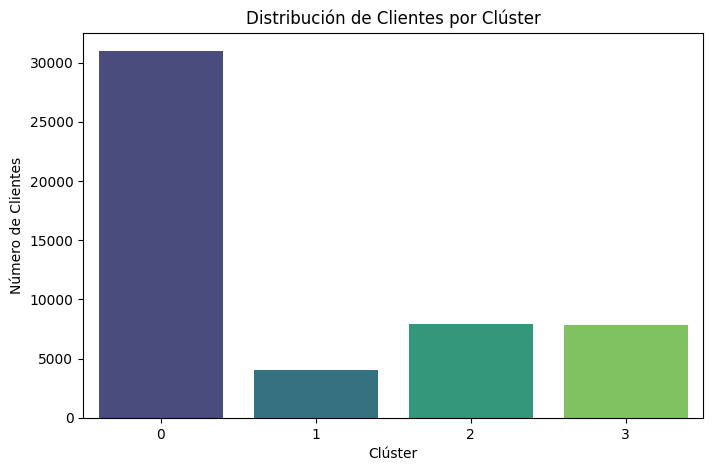

✅ Clústeres creados y almacenados en la tabla 'customer_segmentation_clusters'.

Muestra de la nueva tabla de clústeres:


,customer_id,cluster
0,30268,0
1,30275,0
2,30290,0
3,41013,3
4,51216,3
5,60388,3
6,84569,1
7,93205,3
8,28465,1
9,91108,1


CPU times: total: 1.44 s
Wall time: 1.07 s


In [9]:
%%time
# ==============================
#    CARGA DE DATOS
# ==============================
query = """
SELECT 
    customer_id,
    total_amount_sum_log,
    avg_order_value_log,
    average_time_transaction_winsorized,
    promo_usage_rate_log,
    avg_promo_discount_log,
    age_winsorized,
    recency_days_log,
    first_purchase_days,
    device_type_mode_encoded,
    traffic_source_mode_encoded,
    most_used_payment_credit_card,
    most_used_payment_gopay,
    most_used_payment_ovo,
    most_used_payment_debit_card,
    most_used_payment_linkaja,
    customer_gender_encoded,
    home_location_freq_encoded
FROM customer_segmentation_normalized
"""

# Leer los datos en un DataFrame
df = pd.read_sql_query(query, engine)
customer_ids = df['customer_id']
df.drop(columns=['customer_id'], inplace=True)

# ==============================
#    ENTRENAMIENTO DE K-MEANS
# ==============================
print("\nEntrenando el modelo K-Means con k=4...")
kmeans = KMeans(n_clusters=4, random_state=42)
df['cluster'] = kmeans.fit_predict(df)

# Crear un DataFrame para almacenar el ID y el clúster asignado
df_clusters = pd.DataFrame({
    'customer_id': customer_ids,
    'cluster': df['cluster']
})

# ==============================
#    ANÁLISIS DE CLÚSTERES
# ==============================
print("\nDistribución de Clientes por Clúster:")
print(df_clusters['cluster'].value_counts())

plt.figure(figsize=(8, 5))
sns.countplot(x='cluster', data=df_clusters, palette='viridis')
plt.title('Distribución de Clientes por Clúster')
plt.xlabel('Clúster')
plt.ylabel('Número de Clientes')
plt.show()

# ==============================
#    GUARDADO EN POSTGRESQL
# ==============================
try:
    df_clusters.to_sql("customer_segmentation_clusters", con=engine, index=False, if_exists="replace")
    print("✅ Clústeres creados y almacenados en la tabla 'customer_segmentation_clusters'.")
except Exception as e:
    print(f"❌ Error al insertar los datos: {e}")

# ==============================
#    VALIDACIÓN EN BASE DE DATOS
# ==============================
query_validation = """
SELECT * 
FROM customer_segmentation_clusters 
LIMIT 10;
"""
df_validation = pd.read_sql_query(query_validation, engine)
print("\nMuestra de la nueva tabla de clústeres:")
display(df_validation)



#### Análisis Estadístico de Clústeres Generados  

---

## Objetivo  
El objetivo de esta fase es realizar un análisis estadístico detallado de los clústeres generados en el modelo **K-Means** con `k=4`. El propósito es identificar las características diferenciadoras de cada segmento, permitiendo una interpretación clara y enfocada en las decisiones de marketing y estrategias de negocio.  

---

## Estrategia  
**Carga de Datos:**  
   - Se extraerán los datos de la tabla `customer_segmentation_normalized` y se unirán con la tabla de clústeres recién creada: `customer_segmentation_clusters`.  

**Análisis Descriptivo por Clúster:**  
   - Se generarán estadísticas descriptivas para cada clúster:  
     - Media  
     - Mediana  
     - Desviación estándar  
     - Mínimo y máximo  

**Comparación entre Clústeres:**  
   - Se evaluarán las diferencias en variables clave para identificar patrones y divergencias entre segmentos.  

**Visualización de Resultados:**  
   - Se crearán gráficos de distribución y boxplots para una interpretación visual clara.  

---

## Objetivos Específicos  
1. Identificar las diferencias en comportamiento de compra, uso de dispositivos, género, localización y métodos de pago entre los clústeres.  
2. Detectar patrones de alto valor y clientes con mayor fidelización.  
3. Definir estrategias específicas para cada grupo con base en las diferencias observadas.  

---

## Próximos Pasos  
1. Realizar la carga de datos y el análisis estadístico de cada clúster.  
2. Visualizar los resultados para una interpretación clara.  
3. Preparar un resumen de insights clave y recomendaciones para marketing.  

---


# Asignación de Clientes Inactivos al Clúster -1  

---

## Objetivo  
El objetivo de este proceso fue asignar a los clientes inactivos del dataset a un clúster especial identificado como **-1**. De esta manera, se pueden diferenciar claramente de los clústeres activos generados por el modelo K-Means, permitiendo un análisis segmentado y estructurado.  

---

## Estrategia  
1. **Identificación de Clientes Inactivos:**  
   - Se extrajeron los registros de la tabla `customer_segmentation_inactives`.  
   - Estos clientes no habían registrado sesiones activas, por lo que no podían ser clasificados por el modelo K-Means.  

2. **Asignación del Clúster -1:**  
   - Se creó una nueva columna llamada `cluster` y se asignó el valor **-1** a todos los registros.  
   - Este valor permite identificar rápidamente que pertenecen a un grupo separado, sin actividad reciente.  

3. **Unión con la Tabla de Clústeres:**  
   - Se cargó la tabla `customer_segmentation_clusters` donde ya estaban asignados los clústeres activos (`0`, `1`, `2` y `3`).  
   - Se realizó un `concat` para unir ambos datasets.  
   - Se actualizó la tabla en PostgreSQL para que incluya tanto a los activos como a los inactivos.  

---

## Resultados Obtenidos  
- Se añadieron **N** clientes inactivos al clúster `-1`.  
- Ahora la tabla `customer_segmentation_clusters` contiene tanto clientes segmentados por K-Means como aquellos sin actividad.  

---

## Ventajas del Método  
1. **Segmentación Clara:** Los clientes inactivos están perfectamente identificados y diferenciados de los activos.  
2. **Análisis Estructurado:** Se puede realizar un análisis específico para entender el comportamiento y características de los inactivos.  
3. **Preparación para Marketing:** Permite definir estrategias específicas para reactivar a estos clientes.  

---

## Próximos Pasos  
1. Realizar un análisis exploratorio para entender las características del clúster `-1`.  
2. Visualización de las diferencias entre los clústeres activos y los inactivos.  
3. Proponer estrategias de reactivación para estos usuarios.  

---


In [10]:
%%time
# ==============================
#    CARGA DE CLIENTES INACTIVOS
# ==============================
print("\nCargando clientes inactivos...")
query_inactivos = """
SELECT customer_id
FROM customer_segmentation_inactives
"""
df_inactivos = pd.read_sql_query(query_inactivos, engine)

# Asignar el clúster -1 para indicar inactividad
df_inactivos['cluster'] = -1

print(f"Clientes inactivos encontrados: {df_inactivos.shape[0]}")

# ==============================
#    CARGA DE LA TABLA DE CLÚSTERES
# ==============================
print("\nCargando tabla de clústeres existentes...")
query_clusters = """
SELECT * 
FROM customer_segmentation_clusters
"""
df_clusters = pd.read_sql_query(query_clusters, engine)

# ==============================
#    UNIÓN DE CLIENTES ACTIVOS E INACTIVOS
# ==============================
print("\nUnificando clientes activos e inactivos...")
df_final = pd.concat([df_clusters, df_inactivos], ignore_index=True)

# ==============================
#    GUARDADO EN POSTGRESQL
# ==============================
try:
    df_final.to_sql("customer_segmentation_clusters", con=engine, index=False, if_exists="replace")
    print("✅ Tabla 'customer_segmentation_clusters' actualizada con clientes inactivos (clúster -1).")
except Exception as e:
    print(f"❌ Error al insertar los datos: {e}")

# ==============================
#    VALIDACIÓN EN BASE DE DATOS
# ==============================
query_validation = """
SELECT * 
FROM customer_segmentation_clusters 
WHERE cluster = -1
LIMIT 10;
"""
df_validation = pd.read_sql_query(query_validation, engine)
print("\nMuestra de clientes inactivos en el clúster -1:")
display(df_validation)



Cargando clientes inactivos...
Clientes inactivos encontrados: 49296

Cargando tabla de clústeres existentes...

Unificando clientes activos e inactivos...
✅ Tabla 'customer_segmentation_clusters' actualizada con clientes inactivos (clúster -1).

Muestra de clientes inactivos en el clúster -1:


,customer_id,cluster
0,34110,-1
1,1288,-1
2,1289,-1
3,1319,-1
4,1314,-1
5,1807,-1
6,59513,-1
7,59518,-1
8,60381,-1
9,1410,-1


CPU times: total: 781 ms
Wall time: 1.1 s


## Análisis Descriptivo de Clústeres (Datos Originales)

---

### **Objetivo del Análisis**
Realizar un análisis descriptivo detallado para cada uno de los clústeres generados (0, 1, 2 y 3) y el clúster adicional de **clientes inactivos (-1)**.  
El objetivo es identificar las diferencias en comportamiento y valor entre los segmentos generados.

---

### **Proceso Aplicado**
1. **Carga de datos originales:**  
   - Se extrajeron los datos completos de la tabla **`customer_segmentation_features`**.

2. **Unión con los clústeres:**  
   - Se realizó un `LEFT JOIN` con la tabla **`customer_segmentation_clusters`** para asignar la etiqueta de clúster a cada cliente.

3. **Análisis descriptivo:**  
   - Cálculo de métricas básicas:
     - Media (`mean`)
     - Mediana (`median`)
     - Desviación Estándar (`std`)
   - Evaluación de diferencias significativas entre clústeres.

4. **Almacenamiento en PostgreSQL:**  
   - El análisis se guardó en una nueva tabla llamada **`customer_cluster_analysis`**.
   - Esta tabla contiene los promedios por clúster para todas las variables del dataset.

---

### Resultados Esperados**
- Identificación clara de segmentos diferenciados:
  - Clústeres activos (0, 1 y 2) mostrando distintos comportamientos de compra y navegación.
  - Clúster de clientes inactivos (-1) para detectar oportunidades de reactivación.

- La información almacenada en PostgreSQL permite realizar consultas directas y visualizaciones en Power BI o Python para análisis posteriores.

---

> **Próximo Paso:** Realizar un análisis detallado de las características de cada clúster para identificar patrones y estrategias de marketing específicas.


In [11]:
%%time
# Eliminar la tabla si ya existe para evitar conflictos
def drop_table_if_exists(engine, table_name):
    with engine.connect() as connection:
        connection.execute(text(f"DROP TABLE IF EXISTS {table_name};"))

# Eliminar la tabla si existe previamente
drop_table_if_exists(engine, 'customer_cluster_analysis')

# Consulta para obtener datos originales y los clústeres
query = """
    SELECT f.*, c.cluster
    FROM customer_segmentation_features f
    LEFT JOIN customer_segmentation_clusters c ON f.customer_id = c.customer_id
"""

# Leer los datos en un DataFrame
df_clusters = pd.read_sql_query(query, engine)

# Filtrar solo las columnas numéricas para el análisis descriptivo
numeric_cols = df_clusters.select_dtypes(include=[np.number]).columns

# Análisis descriptivo agrupado por clúster
cluster_summary = df_clusters[numeric_cols].groupby(df_clusters['cluster']).mean()

# Eliminar duplicados antes de guardar
if 'cluster' in cluster_summary.columns:
    cluster_summary = cluster_summary.drop(columns=['cluster'])

# Guardar el análisis en PostgreSQL
cluster_summary.to_sql(
    'customer_cluster_analysis',
    engine,
    if_exists='replace',
    index=True
)

print("✅ Análisis descriptivo completado y almacenado en 'customer_cluster_analysis'.")

✅ Análisis descriptivo completado y almacenado en 'customer_cluster_analysis'.
CPU times: total: 672 ms
Wall time: 834 ms


In [12]:
# Consulta para obtener el resumen descriptivo de los clústeres
query = """
SELECT * 
FROM customer_cluster_analysis
"""

# Leer los datos en un DataFrame
df_analysis = pd.read_sql_query(query, engine)

# Visualización del análisis descriptivo
print("✅ Análisis Descriptivo de Clústeres")
display(df_analysis.head())

✅ Análisis Descriptivo de Clústeres


,cluster,customer_id,total_amount_sum,product_quantity_sum,num_purchases,avg_order_value,recency_days,first_purchase_days,average_time_transaction,num_sessions,num_events,distinct_product_views,num_searches,promo_usage_rate,avg_promo_discount,home_location_lat,home_location_long,age
0,-1,50195.575807,0.000000e+00,NaN,NaN,0.000000e+00,NaN,1912.898531,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,-5.128030,110.930985,28.938555
1,0,49861.344892,3.200103e+07,51.121658,26.143484,1.327052e+06,1136.439913,2037.314090,26750.167387,26.143484,386.051046,57.350446,36.632122,0.432718,5347.882279,-5.085728,110.937564,28.914310
2,1,49743.842602,1.151860e+06,2.095333,1.161619,1.000488e+06,2260.753227,2389.550894,23036.394225,1.161619,12.135799,3.038977,1.830678,0.000000,NaN,-5.089109,111.010344,28.777805
3,2,49688.623498,1.501630e+06,3.605413,2.305931,7.745328e+05,1799.222967,2371.403314,72651.573688,2.305931,29.651701,6.543822,2.724707,0.804998,5265.301452,-5.067837,110.967043,29.097888
4,3,49768.779915,3.146372e+06,5.033474,2.559189,1.228576e+06,1285.056688,1502.025779,25690.885509,2.559189,28.587021,6.325638,3.353027,0.000000,NaN,-5.099675,110.892648,29.072849


C:\Users\Miguel\AppData\Local\Temp\ipykernel_12944\2572749404.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='cluster', y='num_customers', data=df_clusters, palette='Set2')


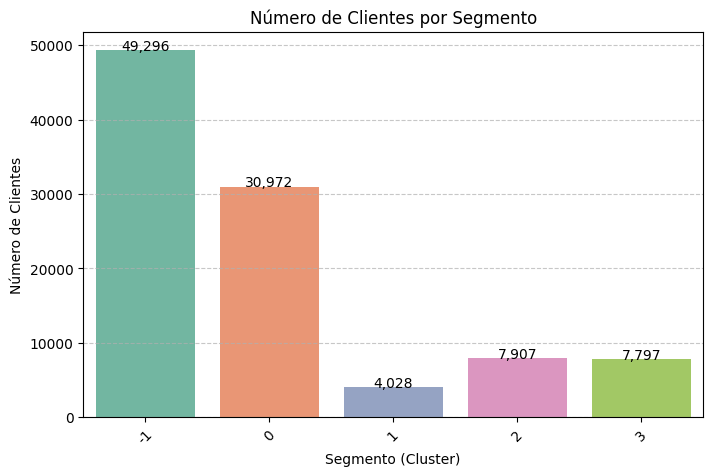

In [13]:
query = """
SELECT cluster, COUNT(customer_id) AS num_customers
FROM customer_segmentation_clusters
GROUP BY cluster
ORDER BY cluster;
"""

# Cargar datos
df_clusters = pd.read_sql_query(query, engine)

# Configuración del gráfico con etiquetas de número de clientes
plt.figure(figsize=(8, 5))
sns.barplot(x='cluster', y='num_customers', data=df_clusters, palette='Set2')
plt.title("Número de Clientes por Segmento")
plt.xlabel("Segmento (Cluster)")
plt.ylabel("Número de Clientes")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Agregar etiquetas numéricas
for index, row in df_clusters.iterrows():
    plt.text(row.name, row.num_customers, f'{row.num_customers:,}', color='black', ha="center")

plt.show()

 Análisis Descriptivo de Clústeres  

---

## Objetivo del Análisis  
El propósito de este análisis es identificar las diferencias en comportamiento y valor entre los clústeres generados por el modelo K-Means (`0`, `1`, `2` y `3`) y el clúster adicional de clientes inactivos (`-1`). El análisis se centra en las métricas clave de comportamiento, compra y navegación, permitiendo identificar patrones y oportunidades de marketing específicas para cada segmento.  

---

## Interpretación de los Resultados  
**Clúster -1 (Inactivos):**  
   - Este grupo no tiene registros de compras ni actividad (`num_purchases`, `avg_order_value` y `total_amount_sum` son 0).  
   - Representa una oportunidad de reactivación mediante campañas específicas.  

#### Clúster 0 – Clientes intensivos y frecuentes
- Alta cantidad de productos adquiridos (`product_quantity_sum`) y número de eventos.
- Elevado número de sesiones y búsquedas.
- Alto uso de promociones (`promo_usage_rate` = 0.43) y elevado descuento medio aplicado.
- Valor medio de pedido moderado (`avg_order_value` ≈ 26.1 €).
- Antigüedad considerable (`first_purchase_days` alto), lo que indica fidelidad.
- Perfil con alta actividad general y valor estratégico para campañas de retención o fidelización.

#### Clúster 1 – Clientes nuevos y de bajo gasto
- Cantidad de productos y número de compras muy bajos.
- Valor medio del pedido también muy bajo (≈ 1.16 €).
- Pocas búsquedas y eventos.
- No utilizan promociones (`promo_usage_rate` = 0.0).
- Antigüedad relativamente baja (`first_purchase_days` alto pero reciente en comparación con otros grupos).
- Este grupo puede corresponder a usuarios nuevos o poco comprometidos, potenciales candidatos para campañas de activación o cross-selling.

#### Clúster 2 – Clientes exploradores o comparadores
- Número de eventos extremadamente alto, pero con pocas compras y bajo ticket medio.
- Alta actividad en la navegación y búsquedas, pero baja conversión.
- Uso moderado de promociones (`promo_usage_rate` = 0.80), lo que puede indicar sensibilidad al precio.
- Requieren una estrategia de remarketing o personalización de ofertas para aumentar la conversión.

#### Clúster 3 – Compradores medios con uso puntual de promociones
- Nivel de compras y gasto superior al Clúster 1 pero inferior al Clúster 0.
- Ticket medio ligeramente más alto (≈ 2.56 €).
- Actividad media-alta en eventos y búsquedas.
- No utilizan promociones (`promo_usage_rate` = 0.0), lo que puede indicar menor sensibilidad al precio.
- Pueden representar clientes satisfechos, no sensibles a ofertas, ideales para estrategias de fidelización sin descuentos agresivos.

---

## Próximos Pasos  
1. Realizar un **Análisis de Diferencias Significativas** (ANOVA) para determinar qué métricas son estadísticamente distintas entre los clústeres.  
2. Identificar las variables clave que explican mejor la segmentación.  
3. Proponer estrategias de marketing específicas para cada clúster, incluyendo el grupo inactivo (-1).  

---


## Visualización Geográfica de los Clústeres

---

### **Objetivo de la Visualización**
El objetivo de la visualización geográfica es entender la **distribución espacial** de los diferentes clústeres obtenidos en el proceso de segmentación. Mediante un mapa interactivo, es posible identificar concentraciones de clientes en regiones específicas, así como posibles patrones geográficos que puedan influir en el comportamiento de compra.

---

### **Detalles Técnicos**
- Se utilizó un `GeoDataFrame` de `geopandas` para almacenar las coordenadas geográficas (`Latitud` y `Longitud`) de cada cliente.
- Se transformaron los datos al sistema de referencia espacial (CRS) `EPSG:3857`, el cual es compatible con mapas web como **OpenStreetMap**.
- Se empleó la librería `contextily` para superponer un mapa base de OpenStreetMap, permitiendo una mejor contextualización geográfica.

---

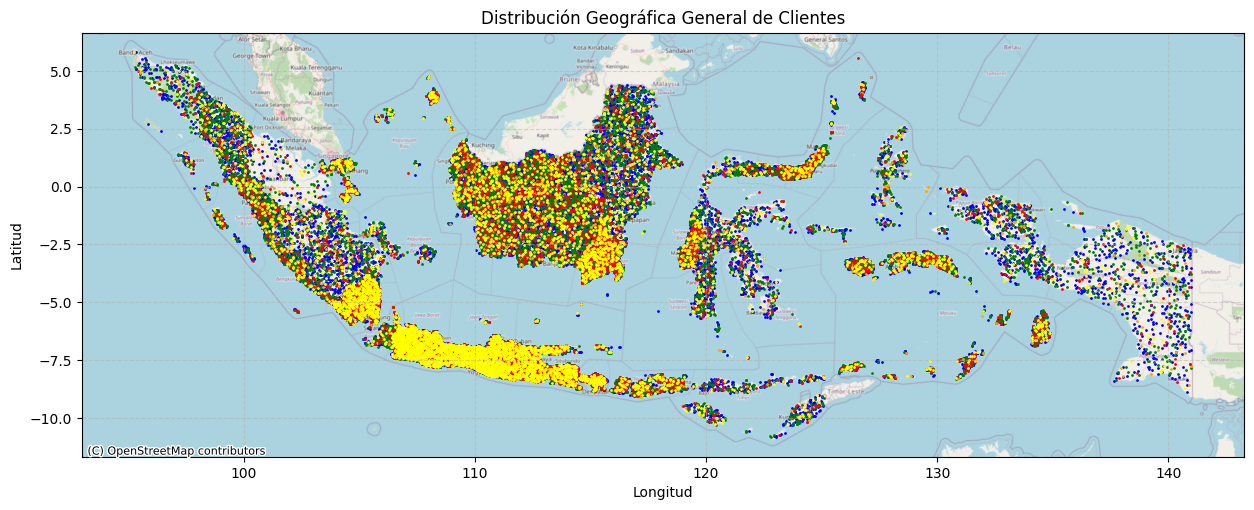

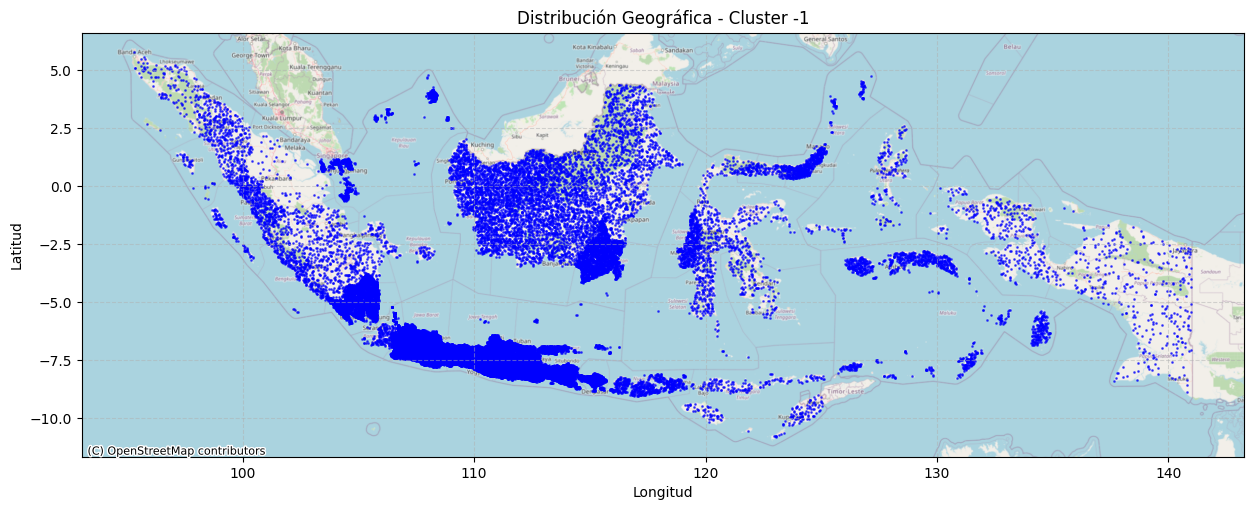

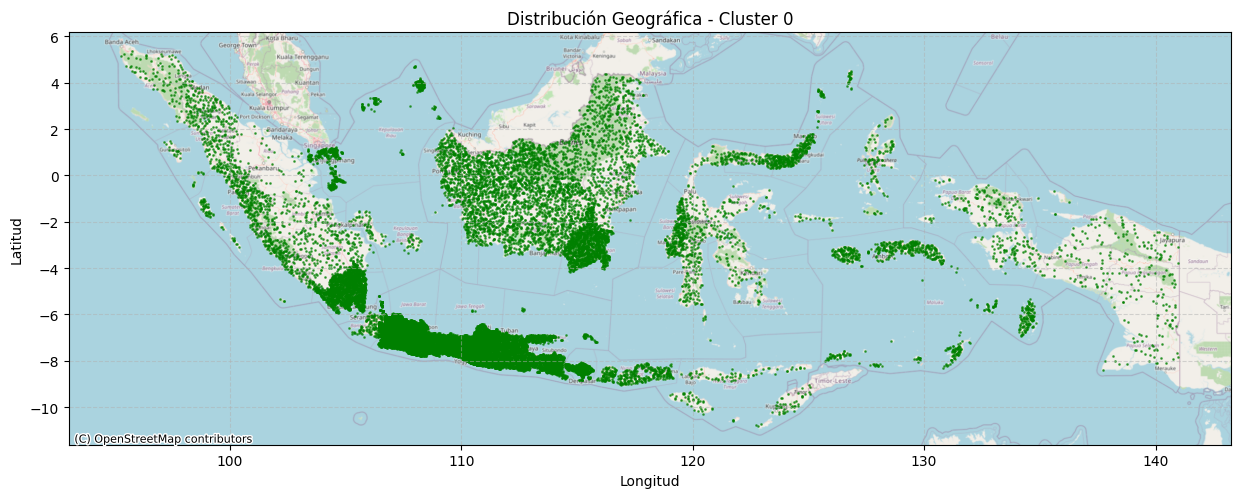

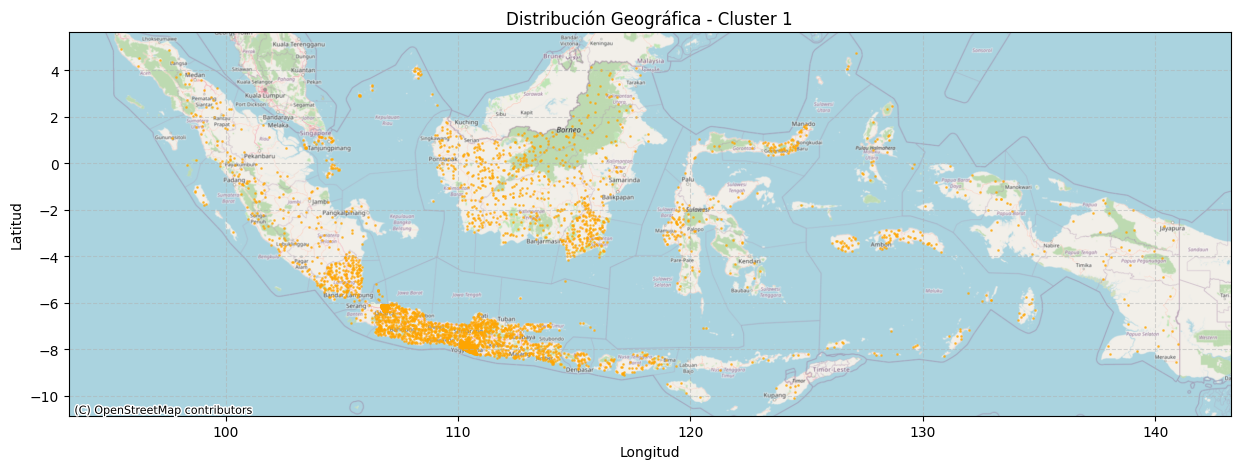

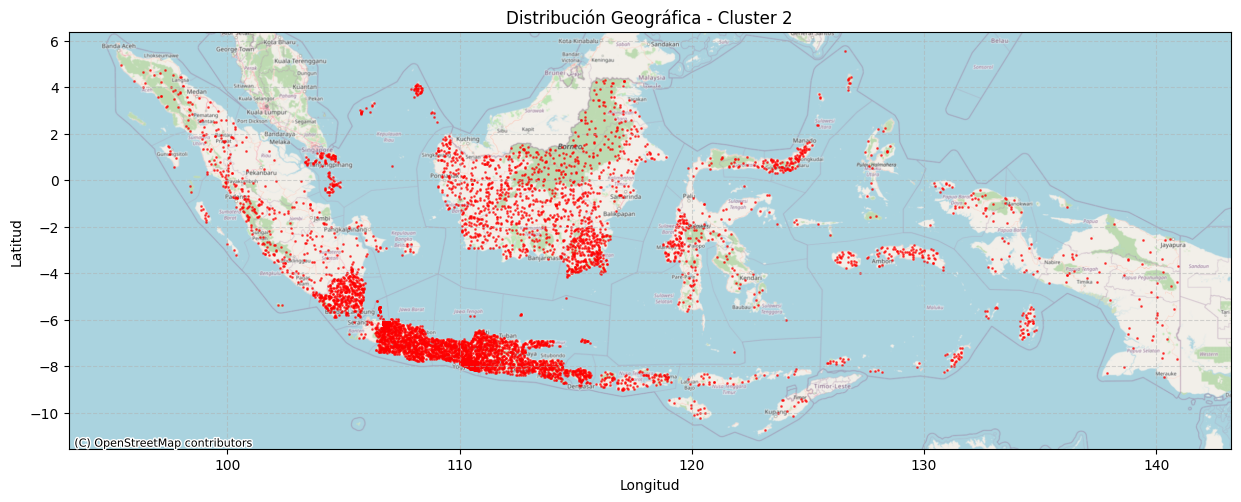

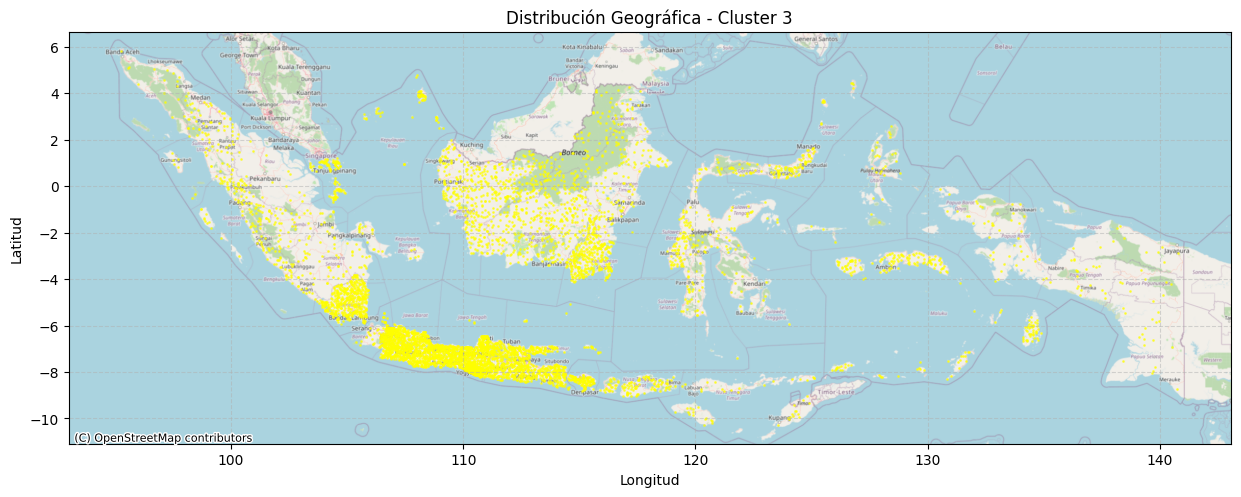

CPU times: total: 8.91 s
Wall time: 13 s


In [15]:
%%time
# Consulta a la tabla que contiene cluster y coordenadas
query = """
SELECT customer_segmentation_features.customer_id, cluster,
       home_location_lat, home_location_long
FROM customer_segmentation_features
JOIN customer_segmentation_clusters
ON customer_segmentation_features.customer_id = customer_segmentation_clusters.customer_id
WHERE home_location_lat IS NOT NULL AND home_location_long IS NOT NULL
"""

df_geo = pd.read_sql_query(query, engine)

# Conversión a GeoDataFrame
gdf = gpd.GeoDataFrame(
    df_geo,
    geometry=gpd.points_from_xy(df_geo["home_location_long"], df_geo["home_location_lat"]),
    crs="EPSG:4326"
)

# Colores y etiquetas para los mapas
colors = ['blue', 'green', 'orange', 'red', 'yellow','cyan']
labels = ['Cluster -1', 'Cluster 0', 'Cluster 1', 'Cluster 2','Cluster 3']

# Mapa General
fig, ax = plt.subplots(figsize=(15, 10))
for idx, (name, group) in enumerate(gdf.groupby('cluster')):
    group.plot(ax=ax, marker='o', color=colors[idx], label=labels[idx], markersize=1)
cx.add_basemap(ax, crs=gdf.crs, source=cx.providers.OpenStreetMap.Mapnik, zoom=6)
plt.title("Distribución Geográfica General de Clientes")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Mapas Individuales
for idx, (name, group) in enumerate(gdf.groupby('cluster')):
    fig, ax = plt.subplots(figsize=(15, 10))
    group.plot(ax=ax, marker='o', color=colors[idx], markersize=1, alpha=0.6)
    cx.add_basemap(ax, crs=gdf.crs, source=cx.providers.OpenStreetMap.Mapnik, zoom=6)
    plt.title(f"Distribución Geográfica - {labels[idx]}")
    plt.xlabel("Longitud")
    plt.ylabel("Latitud")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()


### Distribución Geográfica de los Clústeres

#### Objetivo
El objetivo de esta visualización geográfica es identificar la distribución espacial de los clientes segmentados según los clústeres generados por el modelo K-Means (k = 4), incluyendo el grupo de clientes sin actividad asignados al clúster -1. Este análisis permite detectar concentraciones regionales, patrones de comportamiento y oportunidades estratégicas por ubicación.

---

#### Mapas Generados

**1. Mapa General**
- Representa a todos los clientes, coloreados por clúster:  
  - Azul: Clúster -1 (inactivos)  
  - Verde: Clúster 0  
  - Naranja: Clúster 1  
  - Rojo: Clúster 2  
  - Amarillo: Clúster 3  
- Se observan concentraciones destacadas en las islas de **Java, Sumatra, Kalimantan** y partes del este del archipiélago.

**2. Clúster -1 (Clientes Inactivos)**  
- Representado en **azul**.  
- Alta presencia en todo el país, especialmente en **Java, Sumatra, Borneo (Kalimantan)** y **Sulawesi**.  
- Este grupo representa clientes sin eventos ni compras registrados, y por tanto, un **alto potencial para campañas de reactivación**.

**3. Clúster 0 (Clientes de Alta Actividad y Valor)**  
- Representado en **verde**.  
- Alta concentración en **Java occidental y central**, y en zonas densamente pobladas de Kalimantan y Sumatra.  
- Muestran una actividad transaccional y de navegación muy elevada. Se recomiendan estrategias de **fidelización y mantenimiento**.

**4. Clúster 1 (Clientes Nuevos o Poco Activos)**  
- Representado en **naranja**.  
- Distribuidos de forma más dispersa, aunque con presencia notable en el sur de **Java**, Kalimantan y algunas zonas de **Sulawesi y Papúa**.  
- Presentan bajo número de compras y eventos. Candidatos para **campañas de activación o onboarding personalizado**.

**5. Clúster 2 (Clientes Exploradores)**  
- Representado en **rojo**.  
- Concentración clara en el sur de Java, zonas centrales de Kalimantan y algunas regiones del este del país.  
- Alta actividad de navegación con bajo nivel de compra, lo que sugiere un perfil interesado pero poco convertido. Recomendable implementar **acciones de remarketing y pruebas de promociones**.

**6. Clúster 3 (Compradores Medios sin Promociones)**  
- Representado en **amarillo**.  
- Distribución amplia, especialmente en **Java y Kalimantan**, pero también con fuerte presencia en regiones más orientales.  
- Compradores activos con ticket medio estable, pero sin uso de promociones. Pueden responder bien a **programas de fidelización no basados en descuentos**.

---

#### Conclusiones

- **Clúster -1 (Inactivos):** Numerosos y dispersos, con fuerte presencia en zonas densamente pobladas. Representan una **gran oportunidad de reactivación**, especialmente en Java y Sumatra.
- **Clúster 0 (Alta Actividad y Valor):** Localizados en regiones urbanas estratégicas, deben ser priorizados para programas de **retención y recompra**.
- **Clúster 1 (Baja Actividad):** Dispersión geográfica y bajo compromiso. Se recomienda trabajar su **activación inicial** con contenidos personalizados.
- **Clúster 2 (Exploradores sin conversión):** Pueden convertirse en clientes fieles mediante **intervenciones tácticas** como descuentos, pruebas gratuitas o comunicación dirigida.
- **Clúster 3 (Compradores sin promociones):** Segmento rentable y estable. Potencial para fortalecer la **lealtad sin incentivos económicos directos**.

---
